In [1]:
# =========================
# 0) CONFIG — user option
# =========================

# Pick ONE: 'adult', 'student', 'bank', 'credit'
DATASET = 'adult'
K_MIN, K_MAX = 4, 10
# Global experiment knobs
K_RANGE      = range(4,11)      # k = 4..10
SEEDS        = range(10)         # seeds 0..9
COV_TYPE     = 'full'            # GMM cov type
RANDOM_SEED  = 42
FAIR_PQ      = (1, 2)            # (p,q)-fairlets for MCF
SAVE_ROOT    = 'results'         # root results folder
CF_OUT_DIR   = 'counterfactuals' # where counterfactual CSVs go
ALIGN_METHOD = 'jaccard'         # 'jaccard' or 'kl' for misaligned files
D_EPS_RATIO  = 1.0               # CF explainer hyperparam
IMMUTABLE_IDXS = []              # indices of immutable features (optional)

# Repro
import numpy as np, random
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED)


In [3]:
# =========================
# 1) IMPORTS
# =========================
import os, glob, time, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import argparse

from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

# user libs (assumed available in repo)
from fairtree import build_quadtree, tree_fairlet_decomposition
from gmm_fairlet_decomposition import VanillaFairletDecomposition, MCFFairletDecomposition
from MWD_utils import MHD_GMM_Cost, soft_fairness, MWDG, center_cost, logL
from kmeans_explainer import CFE_explainer


In [4]:
# =========================
# 2) DATASET REGISTRY
# =========================
def dataset_config(name: str):
    """
    Return dict with:
      csv_path, selected_columns, protected_col, prefix
    """
    name = name.lower()
    if name == 'adult':
        return dict(
            csv_path='adult_preprocessed.csv',
            selected_columns=['age','final-weight','education-num','marital-status',
                              'occupation','relationship','capital-gain','hours-per-week',
                              'native-country','income','sex'],  # 'sex' is protected (0/1)
            protected_col='sex',
            prefix='census'
        )
    elif name == 'student':
        return dict(
            csv_path='student_preprocessed.csv',
            selected_columns=['school', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                           'Mjob', 'Fjob', 'traveltime', 'studytime', 'failures', 'schoolsup',
                           'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
                           'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                           'absences', 'sex'],
            protected_col='sex',
            prefix='student'
        )
    elif name == 'bank':
        return dict(
            csv_path='bank_preprocessed.csv',
            selected_columns=['age','balance','duration','marital'],
            protected_col='marital',
            prefix='bank'
        )
    elif name == 'credit':
        return dict(
            csv_path='credit_preprocessed.csv',
            selected_columns=['LIMIT_BAL', 'SEX', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
                                'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE'],
            protected_col='MARRIAGE',
            prefix='credit'
        )
    else:
        raise ValueError(f"Unknown dataset: {name}")


In [5]:
# =========================
# 3) UTILITIES
# =========================

def ensure_dirs(prefix):
    """Create folder structure for a dataset prefix."""
    os.makedirs(f'{SAVE_ROOT}/{prefix}/k_10', exist_ok=True)
    os.makedirs(f'{SAVE_ROOT}/responsibilities', exist_ok=True)
    os.makedirs(f'{SAVE_ROOT}/labels', exist_ok=True)
    os.makedirs(f'{SAVE_ROOT}/misaligned', exist_ok=True)
    os.makedirs(CF_OUT_DIR, exist_ok=True)

def balance_1_to_2(df, protected_col, seed=42):
    """Balance groups to ratio 1:2 (minority:majority)."""
    df = df.dropna().reset_index(drop=True)
    g0 = df[df[protected_col] == 0]
    g1 = df[df[protected_col] == 1]
    minority, majority = (g0, g1) if len(g0) <= len(g1) else (g1, g0)
    n_min = len(minority); n_maj = min(2 * n_min, len(majority))
    bmin = minority.sample(n=n_min, random_state=seed)
    bmaj = majority.sample(n=n_maj, random_state=seed)
    balanced_df = pd.concat([bmin, bmaj], axis=0).sample(frac=1, random_state=seed).reset_index(drop=True)
    return balanced_df

def scale_features(df, protected_col):
    X = df.drop(columns=[protected_col]).copy()
    A = df[protected_col].to_numpy(dtype=int)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(X.values)
    feature_names = X.columns.tolist()
    return data, A, feature_names

def safe_row_normalize(M, eps=1e-12):
    rs = M.sum(axis=1, keepdims=True)
    bad = rs <= eps
    out = M / np.where(bad, 1.0, rs)
    if np.any(bad):
        out[bad.ravel()] = 1.0 / M.shape[1]
    return out

def align_fair_to_unfair_kl(gamma_unfair_NK, gamma_fair_NK, eps=1e-12):
    N, K = gamma_unfair_NK.shape
    Pu = safe_row_normalize(gamma_unfair_NK.T + eps)  # K×N
    Pf = safe_row_normalize(gamma_fair_NK.T + eps)    # K×N
    logPu, logPf = np.log(Pu), np.log(Pf)
    a = np.einsum('kn,kn->k', Pu, logPu)
    D = Pu @ logPf.T
    C = a[:, None] - D
    row_ind, col_ind = linear_sum_assignment(C)
    perm = np.empty(K, dtype=int); perm[row_ind] = col_ind
    gamma_fair_aligned = gamma_fair_NK[:, perm]
    return gamma_fair_aligned, perm

def align_clusters_jaccard(gamma_unfair, gamma_fair):
    labels_unfair = np.argmax(gamma_unfair, axis=1)
    labels_fair   = np.argmax(gamma_fair, axis=1)
    k = gamma_unfair.shape[1]
    C = np.zeros((k, k))
    for i in range(k):
        set_i = set(np.where(labels_unfair == i)[0])
        for j in range(k):
            set_j = set(np.where(labels_fair == j)[0])
            inter = len(set_i & set_j)
            union = len(set_i | set_j)
            sim = inter / union if union > 0 else 0.0
            C[i, j] = 1 - sim
    row_ind, col_ind = linear_sum_assignment(C)
    return {i: col_ind[i] for i in row_ind}

def soft_metric_means(gamma_NK, X_ND, eps=1e-12):
    denom = gamma_NK.sum(axis=0) + eps
    return (gamma_NK.T @ X_ND) / denom[:, None]

def build_mask(n_features, immutable=None):
    m = np.ones(n_features, dtype=int)
    if immutable:
        m[np.asarray(immutable, dtype=int)] = 0
    return m
def _ensure_binary_01(series: pd.Series, pos_values=(1,), neg_values=(0,)):
    """
    Coerce a protected attribute to {0,1}. If already 0/1, return as-is.
    Otherwise: values in pos_values -> 1, in neg_values -> 0.
    If pos/neg sets are not enough, fall back to rank-based mapping.
    """
    s = series.copy()
    uniq = sorted(pd.unique(s.dropna()))
    if set(uniq).issubset({0, 1}):
        return s.astype(int)

    # user-provided mapping
    mapped = pd.Series(np.nan, index=s.index, dtype=float)
    mapped[s.isin(pos_values)] = 1
    mapped[s.isin(neg_values)] = 0
    if mapped.isna().any():
        # fallback: smallest value -> 0, largest -> 1
        vals = sorted(pd.unique(s.dropna()))
        if len(vals) >= 2:
            mapped[s == vals[0]] = 0
            mapped[s == vals[-1]] = 1
    mapped = mapped.fillna(0).astype(int)
    return mapped


def prepare_dataset(csv_path: str,
                    selected_columns: list,
                    protected_col: str,
                    random_seed: int = 42,
                    balance_ratio: int = 2,
                    do_balance: bool = True):
    """
    Load → select → dropna → force protected {0,1} → (optional) 1:2 balance → MinMax scale.
    Returns:
        data (NxD array), A (N,), feature_names (list), balanced_df (DataFrame)
    """
    from sklearn.preprocessing import MinMaxScaler

    df = pd.read_csv(csv_path, low_memory=False)
    df = df[selected_columns].copy()
    df = df.dropna().reset_index(drop=True)

    # force protected to {0,1}
    df[protected_col] = _ensure_binary_01(df[protected_col])

    if do_balance:
        g0 = df[df[protected_col] == 0]
        g1 = df[df[protected_col] == 1]
        minority, majority = (g0, g1) if len(g0) <= len(g1) else (g1, g0)
        n_min = len(minority)
        n_maj_needed = min(balance_ratio * n_min, len(majority))
        balanced_min = minority.sample(n=n_min, random_state=random_seed)
        balanced_maj = majority.sample(n=n_maj_needed, random_state=random_seed)
        df = (pd.concat([balanced_min, balanced_maj], axis=0)
                .sample(frac=1, random_state=random_seed)
                .reset_index(drop=True))

    # split A / X and scale
    A = df[protected_col].to_numpy(dtype=int)
    X = df.drop(columns=[protected_col])
    feature_names = X.columns.tolist()
    scaler = MinMaxScaler()
    data = scaler.fit_transform(X.values)

    # prints (sanity)
    counts = df[protected_col].value_counts().sort_index()
    print("Balanced counts:\n", counts.to_string())
    print("Dataset fraction (mean of A):", A.mean())
    print("Shapes → data:", data.shape, "| A:", A.shape)

    # consistent group naming for MCF:
    # blues = 0-group, reds = 1-group
    reds = np.where(A == 0)[0]
    blues  = np.where(A == 1)[0]
    print("blues (A==0):", len(blues), "| reds (A==1):", len(reds))

    return data, A, feature_names, df


In [6]:
# =========================
# 4) CORE EXPERIMENT
# =========================
def run_experiment(data, A, prefix):
    ensure_dirs(prefix)
    cov_type = COV_TYPE
    p, q = FAIR_PQ

    # accumulators (means/stds per k)
    KMAX = max(K_RANGE)
    span = (KMAX - 2) + 1  # if you ever start at k=2; we’ll map to indices by (k-2)
    Cost_full   = np.zeros((span, 2))
    Cost_mcf    = np.zeros((span, 2))
    Decomp_mcf  = np.zeros((span, 2))
    Balance_full= np.zeros((span, 2))
    Balance_mcf = np.zeros((span, 2))
    Like_mcf    = np.zeros((span, 2))

    N, D = data.shape
    idx0 = np.where(A == 0)[0]
    idx1 = np.where(A == 1)[0]
    
    if len(idx0) >= len(idx1):
        blues = idx0 
        reds  = idx1  
    else:
        blues = idx1 
        reds  = idx0  
    
    for k in K_RANGE:
        B_full=C_full=H_full=[]; D_mcf=[]; B_mcf=[]; C_mcf=[]; H_mcf=[]; L_mcf=[]
        B_full=[]; C_full=[]; H_full=[]
        D_mcf=[]; B_mcf=[]; C_mcf=[]; H_mcf=[]; L_mcf=[]

        print(f"\n[k={k}]")
        for seed in SEEDS:
            # --- Traditional GMM ---
            gm_trad = GaussianMixture(n_components=k, covariance_type=cov_type,
                                      random_state=seed, max_iter=100, n_init=3,
                                      init_params='k-means++').fit(data)
            gamma_cb = gm_trad.predict_proba(data)
            labels_cb = np.argmax(gamma_cb, axis=1)
            w, mu, Sigma = gm_trad.weights_, gm_trad.means_, gm_trad.covariances_
            cost_full = MHD_GMM_Cost(gamma_cb, data, w, mu, Sigma)
            H1, H_ratio1, b1, p1 = soft_fairness(gamma_cb, A)
            H2, H_ratio2, b2, p2 = soft_fairness(gamma_cb, 1-A)
            balance_cb = min(b1, b2); Hratio_cb = min(H_ratio1, H_ratio2)

            C_full.append(cost_full); B_full.append(balance_cb); H_full.append(Hratio_cb)

            # Save responsibilities/labels
            np.save(f'{SAVE_ROOT}/responsibilities/gamma_colorblind_k{k}_seed{seed}_{prefix}.npy', gamma_cb)
            np.save(f'{SAVE_ROOT}/labels/labels_colorblind_k{k}_seed{seed}_{prefix}.npy', labels_cb)

            # --- MCF Fair decomposition ---
            mcf = MCFFairletDecomposition(list(blues), list(reds), q, None, list(data), w, mu, Sigma)
            mcf.compute_distances(); mcf.build_graph(plot_graph=False)
            fairlets, fl_centers, fl_costs = mcf.decompose()

            decomp_cost = sum(center_cost(data[f], w, mu, Sigma) for f in fairlets)

            centers_mean = np.array([np.mean(data[f], axis=0) for f in fairlets])

            # likelihood over fairlets (optional)
            kdim = D
            L_list=[]
            for i, f in enumerate(fairlets):
                for j in range(len(f)):
                    l = f[j]
                    prob_at_x = gm_trad.predict_proba(data[l:l+2])[0]
                    dist,G = MWDG(data[fl_centers[i]], data[f][j], w, mu, Sigma, prob_at_x)
                    L_list.append(logL(kdim, G, dist, G_metric=True))
            decomp_like = float(np.sum(L_list)) if L_list else 0.0

            # fit mixture on repeated centers (Algorithm 1)
            sizes = [len(ff) for ff in fairlets]
            Dbar = np.vstack([np.repeat(centers_mean[i][None, :], sizes[i], axis=0)
                              for i in range(len(sizes))]) if sizes else np.zeros((0, D))
            if len(Dbar) == 0:
                print("[warn] Empty Dbar; skipping seed."); continue

            gm = GaussianMixture(n_components=k, covariance_type=cov_type,
                                 random_state=seed, max_iter=100, n_init=3,
                                 init_params='k-means++').fit(Dbar)
            gamma_f  = gm.predict_proba(Dbar)
            labels_f = np.argmax(gamma_f, axis=1)
            w2, mu2, S2 = gm.weights_, gm.means_, gm.covariances_
            Dbar_cost = MHD_GMM_Cost(gamma_f, Dbar, w2, mu2, S2)
            total_cost = decomp_cost + Dbar_cost

            # assign center responsibilities to members
            center_gamma = gm.predict_proba(centers_mean)
            gamma_f_full = np.zeros((N, k))
            for i, f in enumerate(fairlets):
                gamma_f_full[f] = center_gamma[i]

            H1,Hr1,b1,p1 = soft_fairness(gamma_f_full, A)
            H2,Hr2,b2,p2 = soft_fairness(gamma_f_full, 1-A)
            balance_fair = min(b1, b2); Hratio_fair = min(Hr1, Hr2)

            D_mcf.append(decomp_cost); C_mcf.append(total_cost)
            B_mcf.append(balance_fair); H_mcf.append(Hratio_fair); L_mcf.append(decomp_like)

            # Save fair responsibilities/labels
            np.save(f'{SAVE_ROOT}/responsibilities/gamma_fair_k{k}_seed{seed}_{prefix}.npy',  gamma_f_full)
            np.save(f'{SAVE_ROOT}/labels/labels_fair_k{k}_seed{seed}_{prefix}.npy', labels_f)

        # aggregate per k
        idx = k - 2
        Cost_full[idx,0] = np.mean(C_full);   Cost_full[idx,1] = np.std(C_full)
        Cost_mcf[idx,0]  = np.mean(C_mcf);    Cost_mcf[idx,1]  = np.std(C_mcf)
        Decomp_mcf[idx,0]= np.mean(D_mcf);    Decomp_mcf[idx,1]= np.std(D_mcf)
        Balance_full[idx,0]=np.mean(B_full);  Balance_full[idx,1]=np.std(B_full)
        Balance_mcf[idx,0]= np.mean(B_mcf);   Balance_mcf[idx,1]= np.std(B_mcf)
        Like_mcf[idx,0]   = np.mean(L_mcf);   Like_mcf[idx,1]   = np.std(L_mcf)

    # save aggregates
    outdir = f'{SAVE_ROOT}/{prefix}/k_10'
    for name, arr in [('Cost_full', Cost_full), ('Cost_mcf', Cost_mcf),
                      ('Decomp_mcf', Decomp_mcf), ('Balance_full', Balance_full),
                      ('Balance_mcf', Balance_mcf), ('Like_mcf', Like_mcf)]:
        with open(f'{outdir}/{name}.pkl', 'wb') as f:
            pickle.dump(arr, f)
    print(f"[ok] Saved aggregates → {outdir}")


In [7]:
# =========================
# 5) ALIGNMENT & NMI  (with per-group NMI)
# =========================
def evaluate_alignment(prefix, method='jaccard'):
    """
    Produces:
      - mean/std NMI per k (overall)
      - mean/std NMI per k for each group (A==0 and A==1)  <-- NEW
      - misaligned per group (counts)
      - writes misaligned CSVs per (k,seed) to results/misaligned/
    """
    HAVE_A = ('A' in globals())
    out_mis_dir = f'{SAVE_ROOT}/misaligned'
    os.makedirs(out_mis_dir, exist_ok=True)

    k_values = []
    # overall NMI
    nmi_mean, nmi_std = [], []
    # group-wise NMI
    nmi_g0_mean, nmi_g0_std = [], []
    nmi_g1_mean, nmi_g1_std = [], []
    # misaligned counts by group
    mis0_mean, mis0_std, mis1_mean, mis1_std = [], [], [], []

    for k in K_RANGE:
        nmi_seeds = []
        nmi_g0_seeds, nmi_g1_seeds = [], []
        mis0_seeds, mis1_seeds = [], []
        valid = False

        for seed in SEEDS:
            try:
                gcb = np.load(f'{SAVE_ROOT}/responsibilities/gamma_colorblind_k{k}_seed{seed}_{prefix}.npy')
                gfa = np.load(f'{SAVE_ROOT}/responsibilities/gamma_fair_k{k}_seed{seed}_{prefix}.npy')
                if gcb.shape != gfa.shape:
                    continue

                N, Kc = gcb.shape
                use_A = HAVE_A and (len(A) == N)

                # --- align ---
                if method.lower() == 'kl':
                    gfa_aln, _ = align_fair_to_unfair_kl(gcb, gfa)
                else:
                    mapping = align_clusters_jaccard(gcb, gfa)
                    gfa_aln = np.zeros_like(gfa)
                    for old_idx, new_idx in mapping.items():
                        gfa_aln[:, old_idx] = gfa[:, new_idx]

                # hard labels
                lc  = np.argmax(gcb, axis=1)
                lf  = np.argmax(gfa, axis=1)        # for NMI (as before)
                lfa = np.argmax(gfa_aln, axis=1)    # for misalignment

                # --- overall NMI ---
                nmi_seeds.append(normalized_mutual_info_score(lc, lf))

                # --- group-wise NMI (only if we have A, guard against tiny groups) ---
                if use_A:
                    idx0 = (A == 0)
                    idx1 = (A == 1)
                    if idx0.sum() >= 2:
                        nmi_g0_seeds.append(normalized_mutual_info_score(lc[idx0], lf[idx0]))
                    if idx1.sum() >= 2:
                        nmi_g1_seeds.append(normalized_mutual_info_score(lc[idx1], lf[idx1]))

                # --- misaligned counts per group ---
                mis_mask = (lc != lfa)
                if use_A:
                    counts = np.bincount(A[mis_mask].astype(int), minlength=2)
                    mis0_seeds.append(int(counts[0]))
                    mis1_seeds.append(int(counts[1]))
                else:
                    mis0_seeds.append(0); mis1_seeds.append(0)

                # --- save misaligned CSV ---
                mis_idx = np.where(mis_mask)[0]
                grp_col = (A[mis_idx] if use_A else np.full(len(mis_idx), -1, int))
                df_out = pd.DataFrame({
                    'index': mis_idx,
                    'unfair_label': lc[mis_idx],
                    'fair_label': lf[mis_idx],
                    'aligned_fair_label': lfa[mis_idx],
                    'group': grp_col
                })
                df_out.to_csv(
                    f'{out_mis_dir}/misaligned_points_{method}_k{k}_seed{seed}_{prefix}.csv',
                    index=False
                )

                valid = True
            except FileNotFoundError:
                continue

        if valid:
            k_values.append(k)
            # overall NMI
            nmi_mean.append(float(np.mean(nmi_seeds)))
            nmi_std.append(float(np.std(nmi_seeds)))
            # group-wise NMI (may be empty for some k; use NaN)
            nmi_g0_mean.append(float(np.mean(nmi_g0_seeds)) if len(nmi_g0_seeds) else np.nan)
            nmi_g0_std.append(float(np.std(nmi_g0_seeds))  if len(nmi_g0_seeds) else np.nan)
            nmi_g1_mean.append(float(np.mean(nmi_g1_seeds)) if len(nmi_g1_seeds) else np.nan)
            nmi_g1_std.append(float(np.std(nmi_g1_seeds))  if len(nmi_g1_seeds) else np.nan)
            # misaligned counts
            mis0_mean.append(float(np.mean(mis0_seeds))); mis0_std.append(float(np.std(mis0_seeds)))
            mis1_mean.append(float(np.mean(mis1_seeds))); mis1_std.append(float(np.std(mis1_seeds)))

    return dict(
        k=k_values,
        # overall NMI
        nmi_mean=nmi_mean, nmi_std=nmi_std,
        # per-group NMI
        nmi_g0_mean=nmi_g0_mean, nmi_g0_std=nmi_g0_std,
        nmi_g1_mean=nmi_g1_mean, nmi_g1_std=nmi_g1_std,
        # misaligned counts per group
        mis_s_mean=mis0_mean, mis_s_std=mis0_std,   # A==0 (F)
        mis_m_mean=mis1_mean, mis_m_std=mis1_std    # A==1 (M)
    )


In [57]:
# =========================
# 6) COUNTERFACTUALS
# =========================
def compute_counterfactuals(prefix, feature_names, data, A):
    os.makedirs(CF_OUT_DIR, exist_ok=True)
    mask = build_mask(len(feature_names), IMMUTABLE_IDXS)

    # distance aggregators
    dpk0={k:[] for k in K_RANGE}; dpk1={k:[] for k in K_RANGE}

    for k in K_RANGE:
        per_seed_frames=[]
        for seed in SEEDS:
            gamma_path = f'{SAVE_ROOT}/responsibilities/gamma_colorblind_k{k}_seed{seed}_{prefix}.npy'
            mis_csv    = f'{SAVE_ROOT}/misaligned/misaligned_points_{ALIGN_METHOD}_k{k}_seed{seed}_{prefix}.csv'
            if not (os.path.exists(gamma_path) and os.path.exists(mis_csv)): continue

            gamma_metric = np.load(gamma_path)
            if gamma_metric.shape[0] != data.shape[0]: continue

            # soft centers
            metric_means = soft_metric_means(gamma_metric, data)

            df_mis = pd.read_csv(mis_csv)
            req = {'index','unfair_label','fair_label'}
            if not req.issubset(df_mis.columns): continue

            idx = df_mis['index'].to_numpy()
            src = df_mis['unfair_label'].to_numpy().astype(int)
            tgt = df_mis['fair_label'].to_numpy().astype(int)

            keep = (idx>=0) & (idx<data.shape[0])
            idx, src, tgt = idx[keep], src[keep], tgt[keep]
            if idx.size==0: continue

            factuals = data[idx]; groups=A[idx]

            # headers
            cf_feature_names = [f'cf_{c}' for c in feature_names]
            col_names = feature_names + cf_feature_names + ['group','src_label','tgt_label','cf_l2']

            cache={}; rows=[]; d0=[]; d1=[]
            for i, x in enumerate(factuals):
                s, t = src[i], tgt[i]
                key=(s,t)
                if key not in cache:
                    cache[key] = CFE_explainer(metric_means[s], metric_means[t])
                z = cache[key].compute_counterfactual(x, mask, D_EPS_RATIO)
                if z is None: continue
                dist = float(np.linalg.norm(x - z))
                rows.append(list(x) + list(z) + [int(groups[i]), int(s), int(t), dist])
                if groups[i]==0: d0.append(dist)
                elif groups[i]==1: d1.append(dist)

            if rows:
                df_cf = pd.DataFrame(rows, columns=col_names)
                out = f'{CF_OUT_DIR}/counterfactuals_{ALIGN_METHOD}_k{k}_seed{seed}_{prefix}.csv'
                df_cf.to_csv(out, index=False); per_seed_frames.append(df_cf)
                if d0: dpk0[k].append(np.mean(d0))
                if d1: dpk1[k].append(np.mean(d1))

        if per_seed_frames:
            allk = pd.concat(per_seed_frames, ignore_index=True)
            allk.to_csv(f'{CF_OUT_DIR}/counterfactuals_{ALIGN_METHOD}_k{k}_ALLSEEDS_{prefix}.csv', index=False)

    # Plot CF distance per group (mean±std)
    ks=[]; g0m=[]; g0s=[]; g1m=[]; g1s=[]
    for k in K_RANGE:
        if dpk0[k] or dpk1[k]:
            ks.append(k)
            g0m.append(np.mean(dpk0[k]) if dpk0[k] else np.nan)
            g0s.append(np.std(dpk0[k])  if dpk0[k] else np.nan)
            g1m.append(np.mean(dpk1[k]) if dpk1[k] else np.nan)
            g1s.append(np.std(dpk1[k])  if dpk1[k] else np.nan)

    if ks:
        plt.figure(figsize=(8,6))
        karr=np.array(ks)
        m0=np.array(g0m, float); s0=np.array(g0s, float)
        m1=np.array(g1m, float); s1=np.array(g1s, float)
        mk0 = ~np.isnan(m0); mk1 = ~np.isnan(m1)
        plt.errorbar(karr[mk0], m0[mk0], yerr=s0[mk0], marker='o', linewidth=3, label='soft balance (M)',color='orange')
        plt.errorbar(karr[mk1], m1[mk1], yerr=s1[mk1], marker='s', linewidth=3, label='soft balance (F)',color='navy')
        plt.xlabel(r'$k$', fontsize=16); plt.ylabel('Counterfactual cost', fontsize=16)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.legend(fontsize=15); plt.tight_layout(); plt.savefig(f'{SAVE_ROOT}/{prefix}_cf_l2_vs_k.pdf'); plt.show()


In [15]:
# =========================
# 7) FEATURE CONTRIBUTION
# =========================
def feature_contributions_from_cfs(prefix):
    patt = os.path.join(CF_OUT_DIR, f'counterfactuals_{ALIGN_METHOD}_k*_seed*_{prefix}.csv')
    files = sorted(glob.glob(patt))
    if not files:
        print("[info] No CF files found; skipping feature contributions.")
        return None

    frames=[pd.read_csv(fp) for fp in files]
    df_all=pd.concat(frames, ignore_index=True)

    meta={'group','src_label','tgt_label','cf_l2','k','seed'}
    cols=set(df_all.columns)
    bases=[c for c in cols if not c.startswith('cf_') and c not in meta]
    feature_cols=[c for c in bases if f'cf_{c}' in cols]
    cf_cols=[f'cf_{c}' for c in feature_cols]
    if not feature_cols:
        print("[warn] No (feature, cf_) pairs in CF files."); return None

    X   = df_all[feature_cols].to_numpy(float, copy=False)
    Xcf = df_all[cf_cols].to_numpy(float, copy=False)
    sq  = (Xcf - X)**2
    tot = sq.sum(axis=1, keepdims=True)
    valid = (tot.ravel()>0)
    contrib = np.divide(sq[valid], tot[valid], out=np.zeros_like(sq[valid]), where=(tot[valid]!=0))
    grp_v = df_all.loc[valid,'group'].to_numpy() if 'group' in df_all.columns else np.full(contrib.shape[0], -1, int)

    overall = contrib.mean(axis=0) if contrib.size else np.zeros(len(feature_cols))
    g0 = contrib[grp_v==0].mean(axis=0) if np.any(grp_v==0) else np.zeros(len(feature_cols))
    g1 = contrib[grp_v==1].mean(axis=0) if np.any(grp_v==1) else np.zeros(len(feature_cols))

    summary = (pd.DataFrame({'Feature':feature_cols,
                             'Overall %': overall*100.0,
                             'Group 0 %': g0*100.0,
                             'Group 1 %': g1*100.0})
               .sort_values('Overall %', ascending=False)
               .reset_index(drop=True))
    display(summary.head(15))

    # simple barh using Overall %
    order = summary.sort_values('Overall %').index
    plt.figure(figsize=(10, max(4, 0.5*len(summary))))
    plt.barh(summary.loc[order,'Feature'], summary.loc[order,'Overall %'], color="#FF0051")
    for y, v in enumerate(summary.loc[order,'Overall %']):
        plt.text(v + 0.5, y, f"+{v:.2f}%", va='center', fontsize=10)
    plt.xlabel("Avg Contribution to CF Distance (%)"); plt.title("Feature Contribution (Overall)")
    plt.tight_layout(); plt.savefig(f'{SAVE_ROOT}/{prefix}_feature_contrib_overall.pdf'); plt.show()

    # simple barh using Overall %
    order = summary.sort_values('Group 0 %').index
    plt.figure(figsize=(10, max(4, 0.5*len(summary))))
    plt.barh(summary.loc[order,'Feature'], summary.loc[order,'Group 0 %'], color="#FF0051")
    for y, v in enumerate(summary.loc[order,'Group 0 %']):
        plt.text(v + 0.5, y, f"+{v:.2f}%", va='center', fontsize=10)
    #plt.xlabel("Avg Contribution to CF Distance (%)"); plt.title("Feature Contribution (Overall)")
    plt.tight_layout(); plt.savefig(f'{SAVE_ROOT}/{prefix}_feature_contrib_group_0.pdf'); plt.show()


    # simple barh using Overall %
    order = summary.sort_values('Group 1 %').index
    plt.figure(figsize=(10, max(4, 0.5*len(summary))))
    plt.barh(summary.loc[order,'Feature'], summary.loc[order,'Group 1 %'], color="#FF0051")
    for y, v in enumerate(summary.loc[order,'Group 1 %']):
        plt.text(v + 0.5, y, f"+{v:.2f}%", va='center', fontsize=10)
   # plt.xlabel("Avg Contribution to CF Distance (%)"); plt.title("Feature Contribution (Overall)")
    plt.tight_layout(); plt.savefig(f'{SAVE_ROOT}/{prefix}_feature_contrib_group_1.pdf'); plt.show()


    return summary


In [45]:
# =========================
# Balance plot: Traditional vs Fair (MWD)
# =========================
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_balance_results(save_root: str,
                         prefix: str,
                         k_start: int = 4,
                         k_end: int = 10,
                         base_k: int = 2,
                         out_name: str = None):
    """
    Load Balance_full.pkl (Traditional) and Balance_mcf.pkl (Fair MWD)
    and plot mean ± std across the chosen k-range.

    Parameters
    ----------
    save_root : str
        Root folder where results are stored (e.g., 'results').
    prefix : str
        Dataset prefix used in your pipeline (e.g., 'census', 'bank', 'student', 'credit').
    k_start, k_end : int
        Inclusive range of k to plot.
    base_k : int
        The k value that corresponds to row index 0 in the saved arrays.
        In your experiments it's usually 2 → row i corresponds to k = base_k + i.
    out_name : str or None
        If provided, saves the figure to this filename; otherwise uses a default.

    Returns
    -------
    None
    """
    k_dir = os.path.join(save_root, prefix, "k_10")
    path_trad = os.path.join(k_dir, "Balance_full.pkl")
    path_mwd  = os.path.join(k_dir, "Balance_mcf.pkl")

    if not (os.path.exists(path_trad) and os.path.exists(path_mwd)):
        raise FileNotFoundError(f"Missing balance pkl files under {k_dir}")

    with open(path_trad, "rb") as f:
        balance_traditional = pickle.load(f)  # shape (N,2): mean,std
    with open(path_mwd, "rb") as f:
        balance_mwd = pickle.load(f)

    clusters = np.arange(k_start, k_end + 1)
    idx = clusters - base_k  # map k → row index

    def safe_slice(arr, idx):
        if idx.min() < 0 or idx.max() >= len(arr):
            raise IndexError(
                f"indices {idx.min()}..{idx.max()} out of bounds for array with {len(arr)} rows; "
                f"adjust base_k={base_k} or k range [{k_start},{k_end}]."
            )
        return arr[idx]

    bal_trad_slice = safe_slice(balance_traditional, idx)
    bal_mwd_slice  = safe_slice(balance_mwd, idx)

    balance_data = {
        "Soft Balance": (bal_mwd_slice[:, 0],  bal_mwd_slice[:, 1]),
        "Traditional": (bal_trad_slice[:, 0], bal_trad_slice[:, 1]),
    }

    fig, ax = plt.subplots(figsize=(8, 6))
    colors  = {"Soft Balance": "teal", "Traditional": "firebrick"}
    markers = {"Soft Balance": "^",    "Traditional": "D"}

    for label, (mean, std) in balance_data.items():
        ax.errorbar(
            clusters, mean, yerr=std,
            label=f'Soft Balance' if label != 'Traditional' else 'GMM',
            marker=markers[label], linestyle="-", color=colors[label], capsize=3
        )

    ax.set_xlabel(r"$k$", fontsize=20)
    ax.set_ylabel("Balance", fontsize=20)
    ax.set_xticks(clusters)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.legend(loc="center right", fontsize=14)
    plt.tight_layout()

    out_name = f"balance_soft_{prefix}_{k_start}-{k_end}.pdf"
    plt.savefig(out_name)
    plt.show()
    print(f"[ok] saved plot → {out_name}")


In [21]:
# =========================================
# Plots for: misaligned per group, NMI cost (overall), NMI cost (per group)
# =========================================
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_alignment_figures(
    results: dict,
    prefix: str,
    out_dir: str = ".",
    k_ticks=None,
    group_labels=("soft balance (F)", "soft balance (M)"),
    colors=("navy", "orange")
):
    """
    results: dict returned by evaluate_alignment (must contain keys below)
    prefix : dataset tag used in filenames (e.g., 'census', 'bank', ...)
    out_dir: where to save figures
    """
    os.makedirs(out_dir, exist_ok=True)

    k = np.array(results["k"])
    if k_ticks is None:
        k_ticks = k

    # ---------- (1) Misaligned cost per group ----------
    plt.figure(figsize=(8, 6))
    plt.errorbar(
        k, results["mis_s_mean"], yerr=results["mis_s_mean"],
        label=group_labels[0], color=colors[0], marker="s", linewidth=3
    )
    plt.errorbar(
        k, results["mis_m_mean"], yerr=results["mis_m_std"],
        label=group_labels[1], color=colors[1], marker="s", linewidth=3
    )
    plt.xlabel(r"$k$", fontsize=20)
    plt.ylabel("Misaligned cost", fontsize=18)
    plt.xticks(k_ticks, fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=13)
    plt.tight_layout()
    fpath1 = os.path.join(out_dir, f"misaligned_cost_per_group_{prefix}.pdf")
    plt.savefig(fpath1)
    plt.show()

    # ---------- (2) Overall NMI cost ----------
    # (NMI cost = 1 - mean NMI; error bars = std of NMI)
    plt.figure(figsize=(8, 6))
    plt.errorbar(
        k, [1.0 - x for x in results["nmi_mean"]],
        yerr=results["nmi_std"], color="red", marker="s", linewidth=3
    )
    plt.xlabel(r"$k$", fontsize=20)
    plt.ylabel("NMI cost", fontsize=18)
    plt.xticks(k_ticks, fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    fpath2 = os.path.join(out_dir, f"nmi_cost_{prefix}.pdf")
    plt.savefig(fpath2)
    plt.show()

    # ---------- (3) Group-wise NMI cost ----------
    # Guard against NaNs if a group had no samples for some seeds
    g0 = np.array(results["nmi_g0_mean"], float)
    g1 = np.array(results["nmi_g1_mean"], float)
    g0_std = np.array(results["nmi_g0_std"], float)
    g1_std = np.array(results["nmi_g1_std"], float)

    mask0 = ~np.isnan(g0)
    mask1 = ~np.isnan(g1)

    plt.figure(figsize=(8, 6))
    if mask0.any():
        plt.errorbar(
            k[mask0], 1.0 - g0[mask0], yerr=g0_std[mask0],
            label=group_labels[0], color=colors[0], marker="o", linewidth=3
        )
    if mask1.any():
        plt.errorbar(
            k[mask1], 1.0 - g1[mask1], yerr=g1_std[mask1],
            label=group_labels[1], color=colors[1], marker="s", linewidth=3
        )
    plt.xlabel(r"$k$", fontsize=20)
    plt.ylabel("NMI cost", fontsize=18)
    plt.xticks(k_ticks, fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=13)
    plt.tight_layout()
    fpath3 = os.path.join(out_dir, f"nmi_cost_groups_{prefix}.pdf")
    plt.savefig(fpath3)
    plt.show()

    print("[ok] saved:")
    print("  ", fpath1)
    print("  ", fpath2)
    print("  ", fpath3)


[cfg] dataset=adult prefix=census
Balanced counts:
 0    344
1    656
Dataset fraction (mean of A): 0.656
Shapes → data: (1000, 10) | A: (1000,)
blues (A==0): 656 | reds (A==1): 344

[k=4]
Time taken to compute MCF solution - 370.729 seconds.
344 fairlets have been identified.
Time taken to compute MCF solution - 186.014 seconds.
344 fairlets have been identified.
Time taken to compute MCF solution - 190.410 seconds.
338 fairlets have been identified.
Time taken to compute MCF solution - 192.527 seconds.
344 fairlets have been identified.
Time taken to compute MCF solution - 189.440 seconds.
344 fairlets have been identified.
Time taken to compute MCF solution - 190.464 seconds.
344 fairlets have been identified.
Time taken to compute MCF solution - 193.656 seconds.
344 fairlets have been identified.
Time taken to compute MCF solution - 197.924 seconds.
344 fairlets have been identified.
Time taken to compute MCF solution - 194.260 seconds.
344 fairlets have been identified.
Time taken

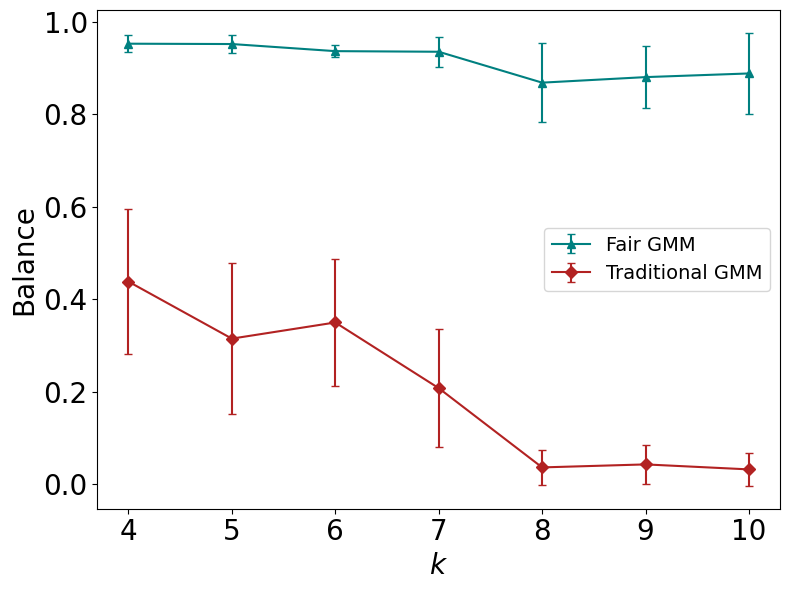

[ok] saved plot → balance_soft_census_4-10.pdf


NameError: name 'metrics' is not defined

In [23]:
# =========================
# 8) RUNNER
# =========================
cfg = dataset_config(DATASET)
CSV_PATH       = cfg['csv_path']
SELECTED_COLS  = cfg['selected_columns']
PROTECTED_COL  = cfg['protected_col']
PREFIX         = cfg['prefix']

print(f"[cfg] dataset={DATASET} prefix={PREFIX}")
ensure_dirs(PREFIX)
data, A, feature_names, balanced_df = prepare_dataset(
    csv_path=cfg['csv_path'],
    selected_columns=cfg['selected_columns'],
    protected_col=cfg['protected_col'],
    random_seed=RANDOM_SEED,
    balance_ratio=2,
    do_balance=True,  # enforce balancing
)

# Load
raw = pd.read_csv(CSV_PATH, low_memory=False)[SELECTED_COLS].copy()
# Balance + scale
balanced = balance_1_to_2(raw, PROTECTED_COL, seed=RANDOM_SEED)
data, A, feature_names = scale_features(balanced, PROTECTED_COL)

# 1) GMM experiments (Traditional + MCF Fair)
run_experiment(data, A, PREFIX)

# 2) Alignment + NMI + misaligned CSVs (choose ALIGN_METHOD at top)
print("[ok] alignment metrics computed.")

plot_alignment_figures(results=metrics, prefix=PREFIX, out_dir=".")


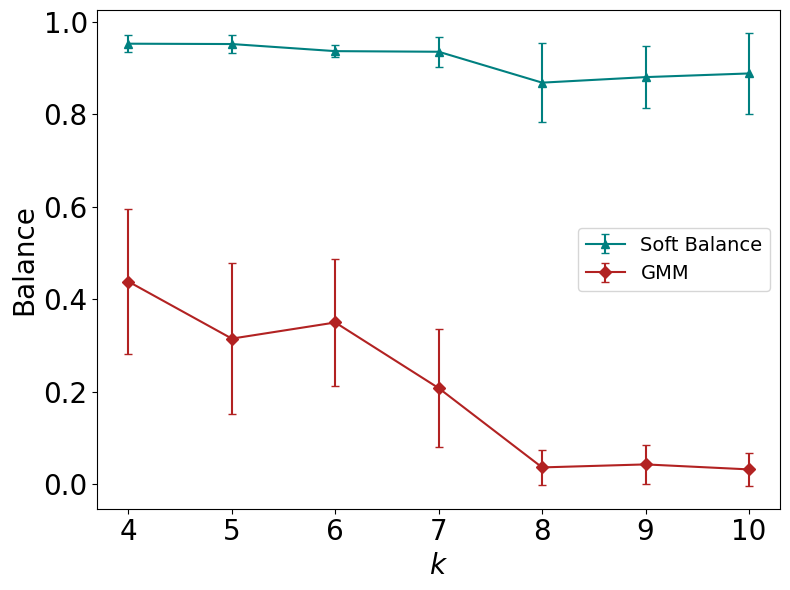

[ok] saved plot → balance_soft_census_4-10.pdf


In [47]:
plot_balance_results(
    save_root=SAVE_ROOT,
    prefix=PREFIX,            # <-- was just PREFIX (positional)
    k_start=K_MIN,            # <-- was k_star
    k_end=K_MAX,
    base_k=2,
    out_name=f"balance_soft_{PREFIX}_{K_MIN}-{K_MAX}.pdf"
)

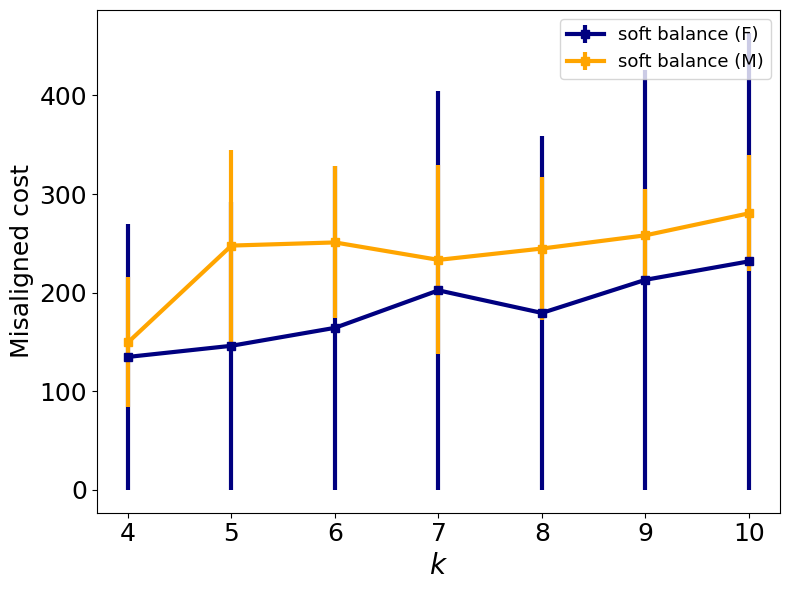

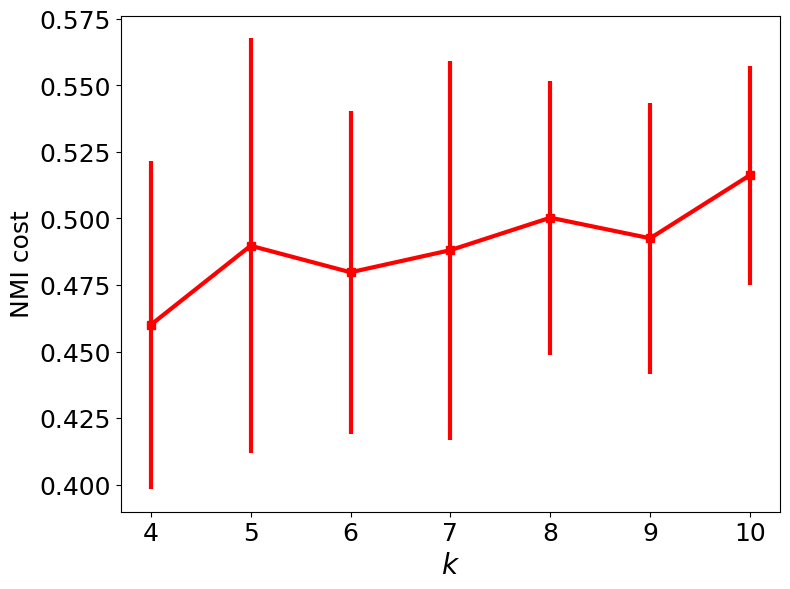

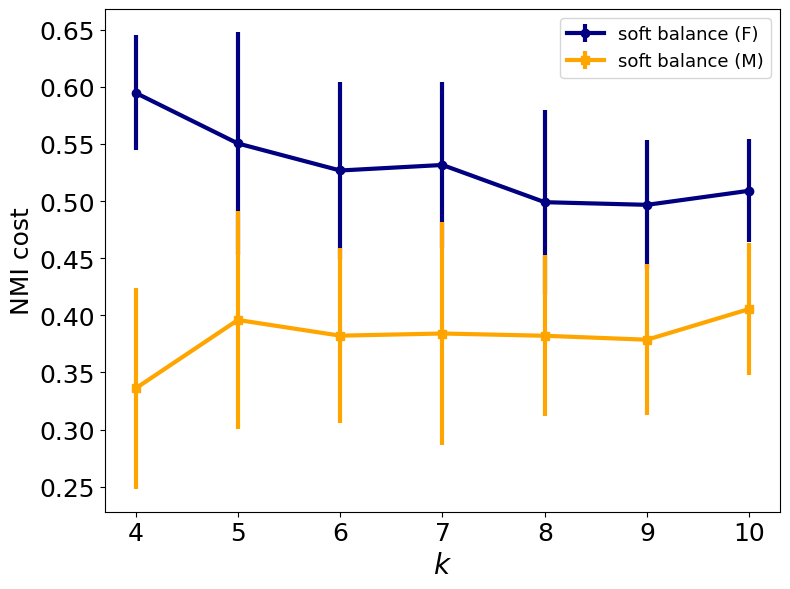

[ok] saved:
   .\misaligned_cost_per_group_census.pdf
   .\nmi_cost_census.pdf
   .\nmi_cost_groups_census.pdf


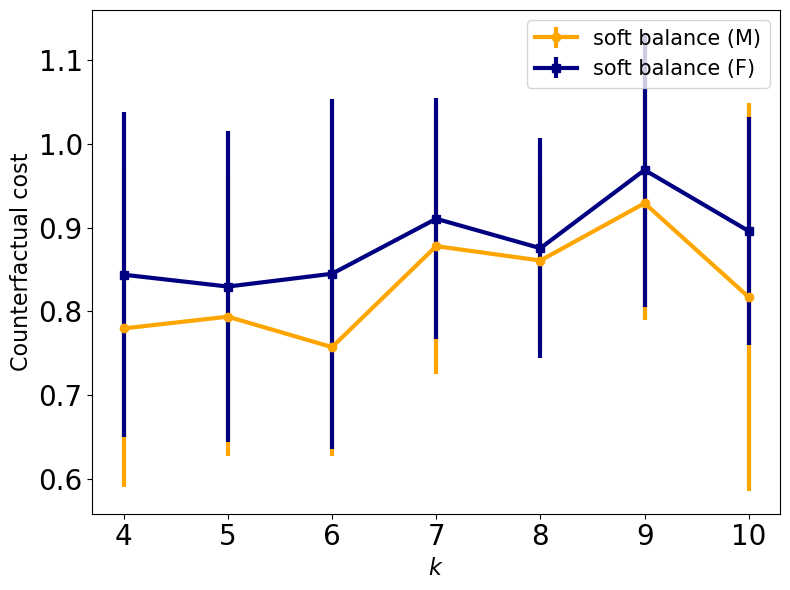

In [59]:
metrics = evaluate_alignment(PREFIX, method=ALIGN_METHOD)
plot_alignment_figures(results=metrics, prefix=PREFIX, out_dir=".")
# 3) Counterfactuals for misaligned & CF distance plots
compute_counterfactuals(PREFIX, feature_names, data, A)


,Feature,Overall %,Group 0 %,Group 1 %
0,income,36.375282,29.837022,41.336927
1,relationship,23.559413,25.659060,21.966068
2,marital-status,16.173628,17.412709,15.233334
3,native-country,13.684476,15.818142,12.065315
4,age,5.631157,7.284640,4.376390
5,education-num,1.638934,1.475843,1.762698
6,occupation,1.462135,1.026889,1.792428
7,hours-per-week,0.674210,0.717175,0.641606
8,capital-gain,0.414626,0.315847,0.489585
9,final-weight,0.386139,0.452672,0.335649


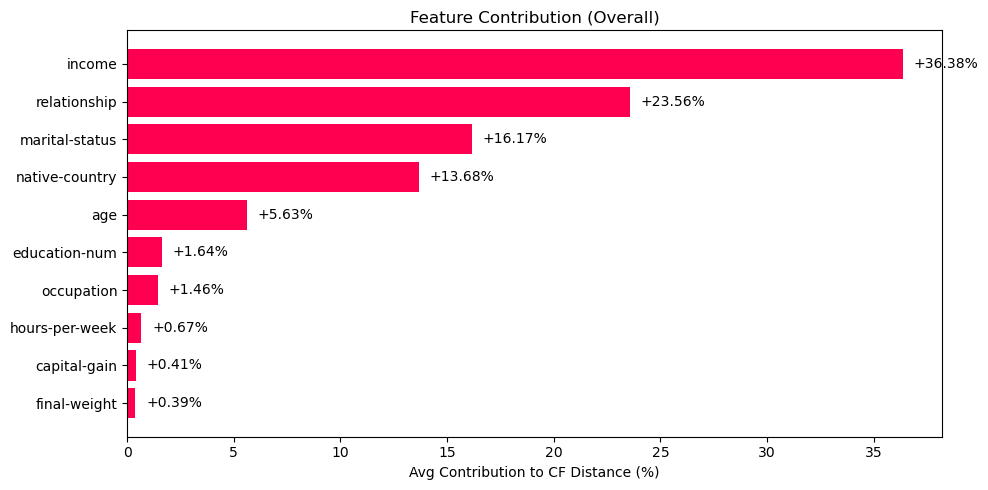

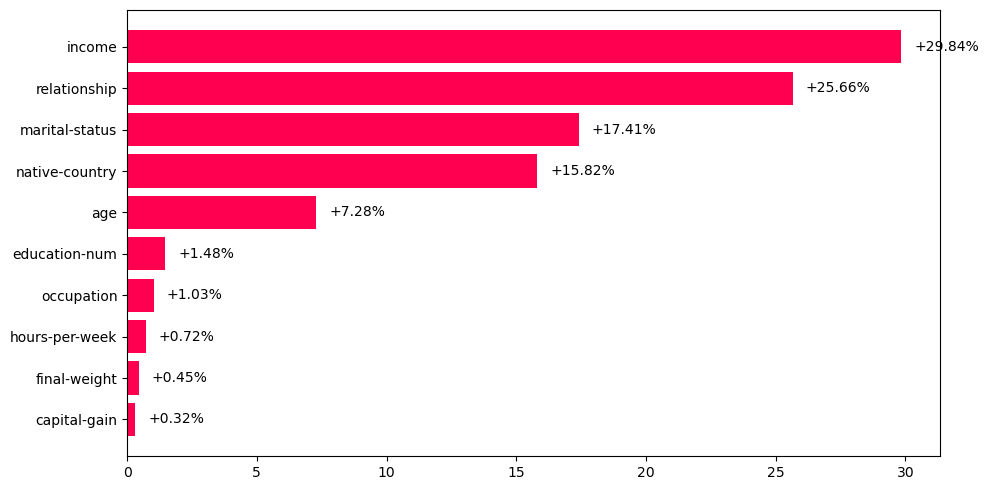

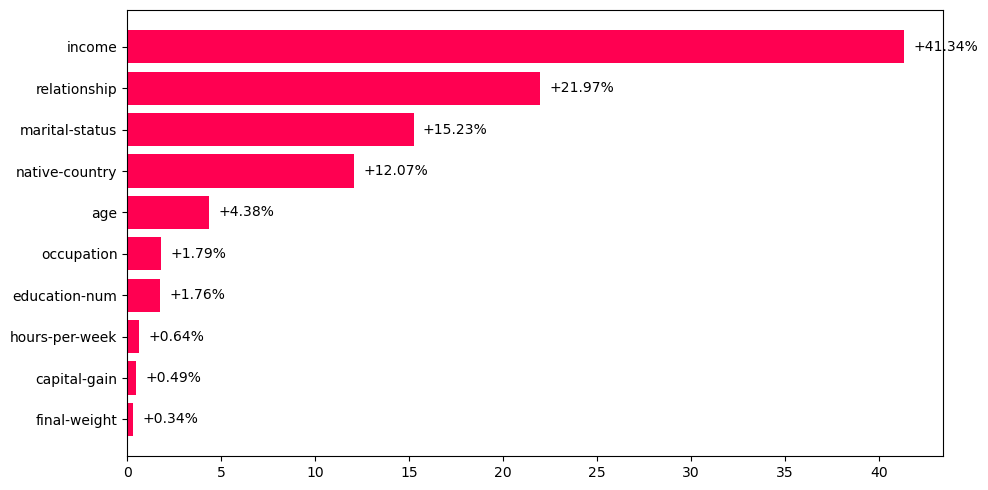

In [37]:
summary = feature_contributions_from_cfs(PREFIX)
